* Submit the assignment with roll_number as *roll_number*.ipynb file.

# Task-1 : Implement VGG16 on Food101 dataset.
Your first task would be to implement the VGG16 architecture model class and train a classification model on the Food101 dataset using the above architecture. The details of the dataset are given below.  

### 1.1 Import packages
Some packages are imported. However, you would need to import any other package that is required in the implementation that you feel is required. But do keep in mind, your model shouldn't be imported. It has to be implemented using the basic convolution layers.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.optim as optim
import random
import os
from torch.utils.data import Dataset,DataLoader

### 1.2. Dataset
The Food-101 is a challenging data set of 101 food categories with 101,000 images. All images were rescaled to have a maximum side length of 512 pixels. Implementing the below cell will allow you to download the dataset into your colab directory under ```/data/food-101```.
Inside the directory you would find the information about the dataset and also a ReadMe.txt file.

Now, the image size of the dataset is ```(512,512,3)```. However, the model expects the image to be of the size ```(224,224,3)```. Now using the transforms method, write a composed transformation where you implement the resize as well as convert to tensor function. Do some basic preprocessing as well, Normalisation, Standardization etc. \
Hint : use the ``` transform.Compose() ``` method.




In [3]:
### YOUR CODE STARTS HERE ###
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resizing the image to (224, 224)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizing the image
])

### YOUR CODE ENDS HERE ###

In [4]:
# Setup training data
train_data = datasets.Food101(
    root="data",
    split="train", # get training data
    download=True,
    transform=transform
)

# Setup testing data
test_data = datasets.Food101(
    root="data",
    split="test", # get test data
    download=True,
    transform=transform
)

100%|██████████| 4996278331/4996278331 [04:38<00:00, 17948685.54it/s]


Extracting data/food-101.tar.gz to data


For visualization, we randomly select 10 classes of the dataset and plot corresponding images.

In [5]:
class ReducedFood101Dataset(Dataset):
    def __init__(self, original_dataset, transform=None, samples_per_class=5):
        """
        Args:
            original_dataset (Dataset): Original PyTorch dataset.
            transform (callable, optional): Optional transform to be applied on a sample.
            samples_per_class (int): Number of samples to take from each class.
        """
        self.original_dataset = original_dataset
        self.transform = transform
        self.samples_per_class = samples_per_class
        self.data = []

        # Reducing the dataset
        self.reduce_dataset()

    def reduce_dataset(self):
        class_counts = {}
        # Counting  number of samples per class
        for idx in range(len(self.original_dataset)):
            _, label = self.original_dataset[idx]
            if label not in class_counts:
                class_counts[label] = 1
            else:
                class_counts[label] += 1

        # Randomly selecting 'samples_per_class' images from each class
        for idx in range(len(self.original_dataset)):
            image, label = self.original_dataset[idx]
            if class_counts[label] <= self.samples_per_class:
                self.data.append((image, label))
            else:
                class_counts[label] -= 1
                if random.random() < self.samples_per_class / class_counts[label]:
                    self.data.append((image, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


In [6]:
#Reducing train data
train_data = ReducedFood101Dataset(train_data,samples_per_class = 5)

In [7]:
#Reducing test data
test_data = ReducedFood101Dataset(test_data,samples_per_class = 5)

In [8]:

image,label = train_data[0]
image ,label

(tensor([[[-1.6042, -1.6384, -1.6727,  ..., -2.0665, -2.0494, -2.0152],
          [-1.6384, -1.6555, -1.6727,  ..., -2.0323, -2.0665, -2.0665],
          [-1.7240, -1.6898, -1.6898,  ..., -2.0837, -2.0837, -2.0837],
          ...,
          [-2.0837, -2.0837, -2.0837,  ..., -2.1008, -2.1008, -2.1008],
          [-2.1008, -2.0837, -2.0837,  ..., -2.1008, -2.1008, -2.1008],
          [-2.1008, -2.1008, -2.0665,  ..., -2.1008, -2.1008, -2.1008]],
 
         [[-1.6856, -1.7206, -1.7556,  ..., -1.9832, -1.9657, -1.9307],
          [-1.7206, -1.7381, -1.7556,  ..., -1.9482, -1.9832, -1.9832],
          [-1.8081, -1.7731, -1.7731,  ..., -2.0007, -2.0007, -2.0007],
          ...,
          [-2.0007, -2.0007, -2.0007,  ..., -2.0182, -2.0182, -2.0182],
          [-2.0182, -2.0007, -2.0007,  ..., -2.0182, -2.0182, -2.0182],
          [-2.0182, -2.0182, -1.9832,  ..., -2.0182, -2.0182, -2.0182]],
 
         [[-1.6127, -1.6476, -1.6824,  ..., -1.7870, -1.7696, -1.7347],
          [-1.6476, -1.6650,

In [9]:
image.shape

torch.Size([3, 224, 224])

### 1.3. Prepare Dataloader
Now, in the cell below implement the DataLoader function for the train and test data. You then have to print the length of the train and test dataloaders.

In [10]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

### YOUR CODE STARTS HERE ###
#splitting data into batches of size 32
train_dataloader = DataLoader(train_data,batch_size = BATCH_SIZE,shuffle = True)
test_dataloader = DataLoader(test_data,batch_size = BATCH_SIZE,shuffle = True)
### YOUR CODE ENDS HERE ###



print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Length of train dataloader: 99 batches of 32
Length of test dataloader: 80 batches of 32


In [11]:

train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

### 1.4. VGG16 Architecture
Now, create a model class and implement the VGG16 architecture. The architecture layer is as follows :
![Alt text](https://miro.medium.com/v2/resize:fit:1400/format:webp/0*6VP81rFoLWp10FcG)
![Alt text](https://miro.medium.com/v2/resize:fit:1400/format:webp/0*0M8CobXpNwFDCmOQ)

VGG16 takes input tensor size as 224, 244 with 3 RGB channel. It has 13 convolutional layers, 5 Max Pooling layers, and 3 Dense layers which sum up to 21 layers.



Implement the model class in the given cell below. DONOT change the class name as that would be required in the next cell.

# Task-2 : Finetuning VGG16
In this task, you would use the concept of transfer learning to train a pretrained model of VGG16 on the Food101 dataset. You would use the pretrained model of vgg16 from the pytorch library and use a classification head having the number of classes same as given in the dataset(as like above). Use cross entropy loss and SGD optimizer to train on the training data. Report the accuracy measure of the previous model (from scratch) and this finetuned version. Prepare a graph showing the accuracy of the models.

In [16]:
### YOUR CODE STARTS HERE ###
import torchvision.models as models
#downloading vgg 16 model
vgg16 = models.vgg16(pretrained = True)
num_classes = 101
vgg16.classifier[6] = nn.Linear(4096,num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=learning_rate,momentum = 0.9)
vgg16 = vgg16.to(device)



### YOUR CODE ENDS HERE ###

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 76.7MB/s]


In [17]:
#defining finetune model
def train_finetune_model(model, train_loader, num_epochs):
    train_losses = []
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, epoch_loss))
    return train_losses

In [18]:
num_epochs = 10
#training model
train_losses = train_finetune_model(vgg16, train_loader, num_epochs)

Epoch [1/10], Loss: 4.2833
Epoch [2/10], Loss: 2.9519
Epoch [3/10], Loss: 2.1845
Epoch [4/10], Loss: 1.6282
Epoch [5/10], Loss: 1.1808
Epoch [6/10], Loss: 0.8547
Epoch [7/10], Loss: 0.5540
Epoch [8/10], Loss: 0.4452
Epoch [9/10], Loss: 0.3154
Epoch [10/10], Loss: 0.2549


In [19]:
# Definging function to evaluate model
def evaluate_model(model, test_loader):
    model.eval()  # Setting the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

In [20]:
#evaluating the model
finetuned_accuracy = evaluate_model(vgg16, test_loader)

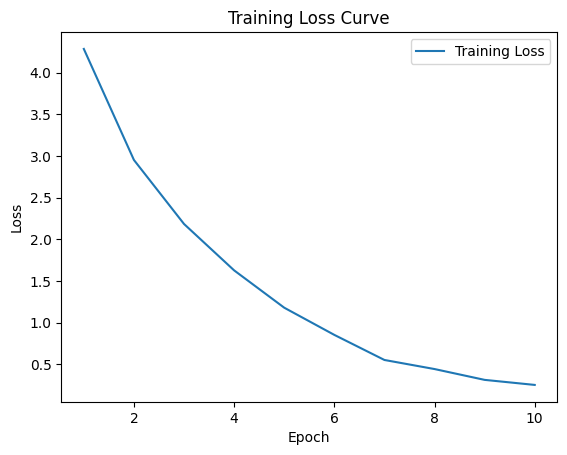

Accuracy of the finetuned model on the test images: 44.83%


In [21]:
# Plotting  the training loss curve
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

#print('Accuracy of the model (from scratch) on the test images: {:.2f}%'.format(accuracy))
print('Accuracy of the finetuned model on the test images: {:.2f}%'.format(finetuned_accuracy))